<a href="https://colab.research.google.com/github/vishal0143/Named-Entity-Recognition-using-LSTMs-with-Keras/blob/main/Named_Entity_Recognition_using_LSTMs_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use('ggplot')

import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
data = pd.read_csv("https://raw.githubusercontent.com/vishal0143/Named-Entity-Recognition-using-LSTMs-with-Keras/main/ner_dataset.csv",
                   encoding='latin1')
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [19]:
print('Number of Unique Words: ', data['Word'].nunique())
print('Number of Unique Tags: ', data['Tag'].nunique())

Number of Unique Words:  35178
Number of Unique Tags:  17


In [20]:
words = list(set(data.Word.values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [21]:
tags = list(set(data.Tag.values))
num_tags = len(tags)
num_tags

17

***Task 1: Retrieve Sentences and Corresponding Tags***

In [22]:
class SentenceGetter(object):
  def __init__(self,data):
    self.n_sent=1
    self.data = data
    agg_func = lambda s: [(w,p,t) for w,p,t in zip(s.Word.values.tolist(),
                                                   s.POS.values.tolist(),
                                                   s.Tag.values.tolist())]
    self.grouped = self.data.groupby('Sentence #').apply(agg_func)
    self.sentences = [s for s in self.grouped]

In [23]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [24]:
sentences[2]

[('Helicopter', 'NN', 'O'),
 ('gunships', 'NNS', 'O'),
 ('Saturday', 'NNP', 'B-tim'),
 ('pounded', 'VBD', 'O'),
 ('militant', 'JJ', 'O'),
 ('hideouts', 'NNS', 'O'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('Orakzai', 'NNP', 'B-geo'),
 ('tribal', 'JJ', 'O'),
 ('region', 'NN', 'O'),
 (',', ',', 'O'),
 ('where', 'WRB', 'O'),
 ('many', 'JJ', 'O'),
 ('Taliban', 'NNP', 'B-org'),
 ('militants', 'NNS', 'O'),
 ('are', 'VBP', 'O'),
 ('believed', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('have', 'VB', 'O'),
 ('fled', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('avoid', 'VB', 'O'),
 ('an', 'DT', 'O'),
 ('earlier', 'JJR', 'O'),
 ('military', 'JJ', 'O'),
 ('offensive', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('nearby', 'JJ', 'O'),
 ('South', 'NNP', 'B-geo'),
 ('Waziristan', 'NNP', 'I-geo'),
 ('.', '.', 'O')]

Task 2: Define Mappings between Sentences and Tags

In [25]:
word2idx = {w:i+1 for i,w in enumerate(words)}
tag2idx = {t:i for i,t in enumerate(tags)}

In [26]:
word2idx

{'USA': 1,
 'unionist': 2,
 'four': 3,
 'resent': 4,
 'Woo-Suk': 5,
 'damper': 6,
 'Golborne': 7,
 '1854': 8,
 'risque': 9,
 'abolish': 10,
 'battering': 11,
 'Manchuria': 12,
 'mitigate': 13,
 'total': 14,
 'Ponte': 15,
 'shed': 16,
 'turbine': 17,
 'Jubran': 18,
 'Ben-David': 19,
 'uninsured': 20,
 'nap': 21,
 'drawing': 22,
 'Farmers': 23,
 'strongmen': 24,
 'Californian': 25,
 'revelation': 26,
 'glitch': 27,
 'Keraterm': 28,
 'cents': 29,
 'importing': 30,
 'Olesgun': 31,
 'by': 32,
 '68-34': 33,
 'refiling': 34,
 'Horobets': 35,
 'capsize': 36,
 'pyramid': 37,
 'Generals': 38,
 'Masjid': 39,
 'Aral': 40,
 'modestly': 41,
 'wrathful': 42,
 'competed': 43,
 'models': 44,
 'Afterwards': 45,
 'Rachel': 46,
 'pro-U.S.': 47,
 'sore': 48,
 'ratify': 49,
 'presidential': 50,
 'Karrada': 51,
 'midwestern': 52,
 'Ningxia': 53,
 'Suicide': 54,
 'resold': 55,
 'proportionately': 56,
 'eliminates': 57,
 'mechanized': 58,
 '24th': 59,
 'unveiled': 60,
 'mile': 61,
 'Federated': 62,
 'soared': 

Task 3: Padding Input Sentences and Create Train/Test Split

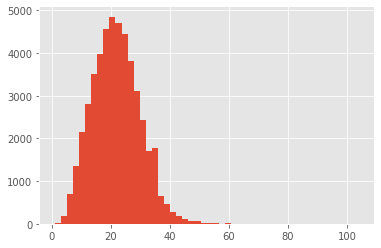

In [27]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences = X, padding = 'post',
                  value = num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding ='post',
                  value = tag2idx["O"])

In [29]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [30]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1,
                                                 random_state = 1)

**Task 3: Build and Compile a Bidirectional LSTM Model**

In [31]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [48]:
input_word = Input(shape= (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

**Task 4:  Train the Model**

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [51]:
#!pip install livelossplot

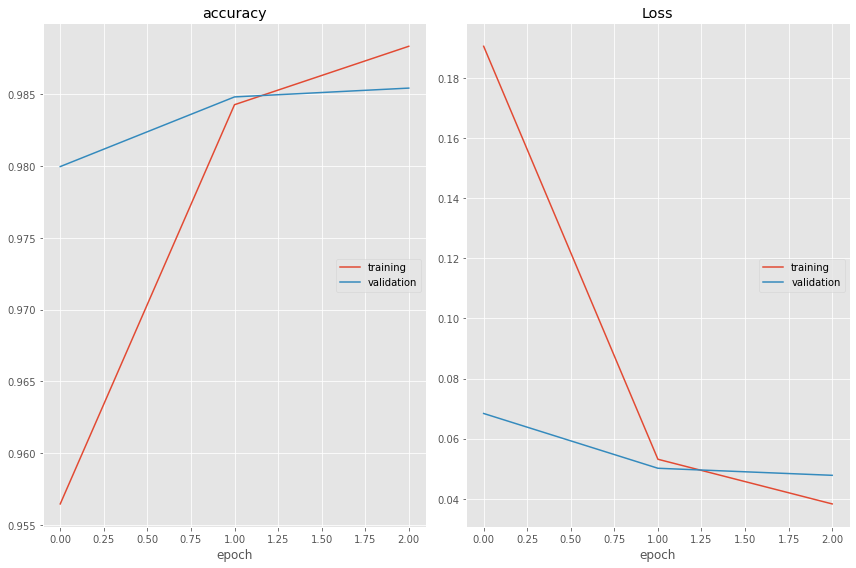

accuracy
	training         	 (min:    0.956, max:    0.988, cur:    0.988)
	validation       	 (min:    0.980, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.038, max:    0.191, cur:    0.038)
	validation       	 (min:    0.048, max:    0.068, cur:    0.048)


In [52]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 2,
                               verbose = 0,
                               mode = 'max',
                               restore_best_weights = False)
callbacks = [PlotLossesCallback(),
             early_stopping]
history = model.fit(x_train,np.array(y_train),
                    validation_split = 0.2,
                    batch_size = 32,
                    epochs = 3,
                    verbose=1,
                    callbacks = callbacks)

In [42]:
!nvidia-smi

Tue Jun  1 06:01:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |    228MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis=-1)
p[0]

array([11, 11, 11, 11, 11, 11, 11, 11,  1, 14, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [57]:
y_true = np.argmax(np.array(y_test),axis=-1)[i]
y_true

array([11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [67]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis=-1)
y_true = np.argmax(np.array(y_test),axis=-1)[i]

print("{:15}{:5}\t {}\n".format('Word','True','Pred'))
print("-"*30)
for w,true,pred in zip(x_test[i],y_true,p[0]):
  print("{:15}{}\t{}".format(words[w-1], tags[true],tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
Pentagon       B-org	B-org
's             O	O
Douglas        B-per	I-org
Feith          I-per	I-org
told           O	O
Turkish        O	B-gpe
Foreign        O	O
Minister       O	O
Abdullah       B-per	I-per
Gul            I-per	I-per
Monday         B-tim	B-tim
the            O	O
United         B-geo	B-geo
States         I-geo	I-geo
is             O	O
committed      O	O
to             O	O
preserving     O	O
Iraq           B-geo	B-geo
's             O	O
territorial    O	O
integrity      O	O
.              O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex          O	O
Timex     